In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
data = pd.read_csv('rainfall.csv', index_col=['date'], parse_dates=['date'])

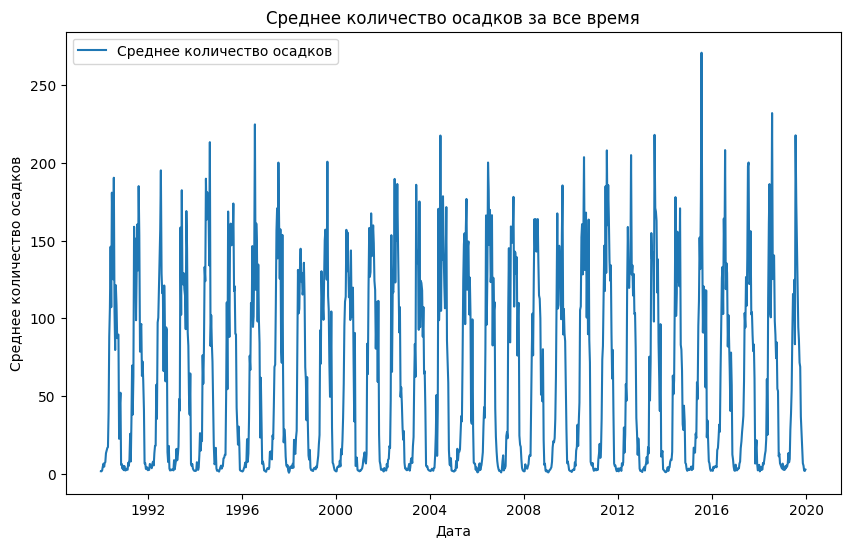

In [ ]:
# Визуализация ряда
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['mean_rainfall'], label='Среднее количество осадков')
plt.title('Среднее количество осадков за все время')
plt.xlabel('Дата')
plt.ylabel('Среднее количество осадков')
plt.legend()
plt.show()
#На основе визуального анализа можно сделать следующие предположения:
#Тренд: временной ряд осадков демонстрирует некоторый тренд, похожий на флет, то есть измменение происходит в двух границах верхней и нижней, ряд не постоянно убывает или постоянно возрастает
#Сезонность: думаю есть сезонная составляющая, которая проявляется в регулярных циклах повышения и понижения осадков в течении года.
#Стационарность: предпологаю, что ряд является стационарным.

In [ ]:
#Делим датасет в пропорции 70/30, 70% для обучения модели и 30% для тестирования её качества.
train_size = int(len(data) * 0.7)
train, test = data.iloc[:train_size], data.iloc[train_size:]
print("Train size:", len(train))
print("Test size:", len(test))

Train size: 754
Test size: 324


**Бейзлайн**

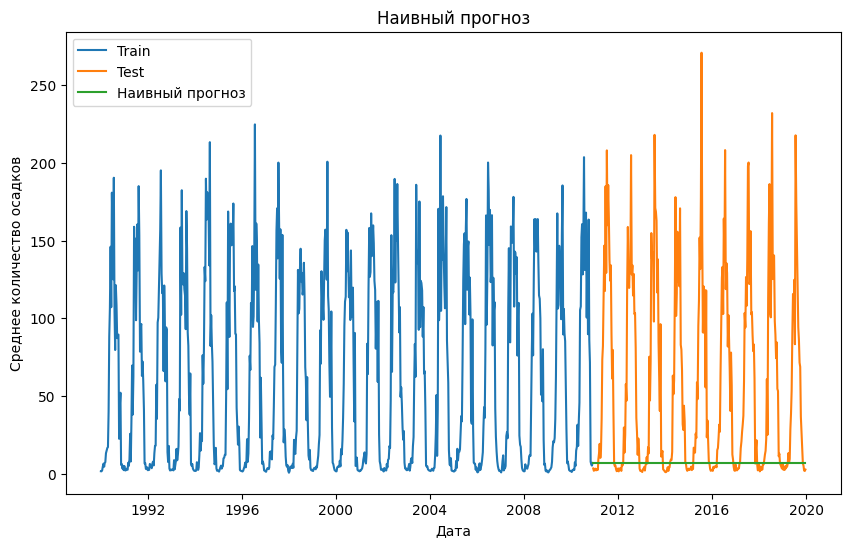

In [ ]:
# Наивный прогноз
naive_forecast = test.copy()
naive_forecast['naive_forecast'] = train['mean_rainfall'].iloc[-1]

# Визуализация результатов работы модели
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['mean_rainfall'], label='Train')
plt.plot(test.index, test['mean_rainfall'], label='Test')
plt.plot(naive_forecast.index, naive_forecast['naive_forecast'], label='Наивный прогноз')
plt.title('Наивный прогноз')
plt.xlabel('Дата')
plt.ylabel('Среднее количество осадков')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_baseline = mean_absolute_error(test['mean_rainfall'], naive_forecast['naive_forecast'])
print("Средняя абсолютная ошибка (MAE) для Наивного прогноза:", mae_baseline)

Средняя абсолютная ошибка (MAE) для Наивного прогноза: 52.45669135802469


Тест Дики-Фуллера

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Тест Дики-Фуллера
results = adfuller(data['mean_rainfall'])
print("p-value:", results[1])
#Из полученного значения p-value, которое крайне мало (практически равно нулю), мы делаем вывод о том, что у нас есть достаточно статистических доказательств для отвержения нулевой гипотезы о наличии единичного корня в модели (и, следовательно, нестационарности ряда).
#Таким образом, ряд данных об осадках является стационарным на основе теста Дики-Фуллера.

p-value: 7.573294206434818e-30


In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Графики анализа "Среднее количество осадков"\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

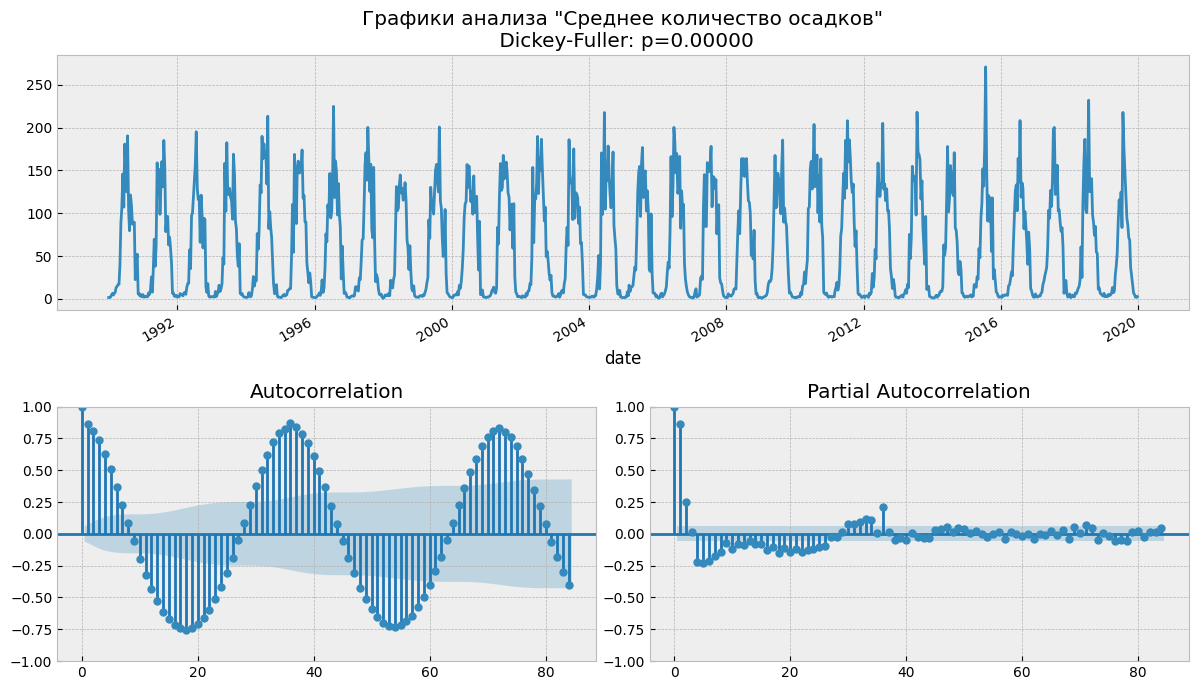

In [ ]:
tsplot(data['mean_rainfall'], lags=84)

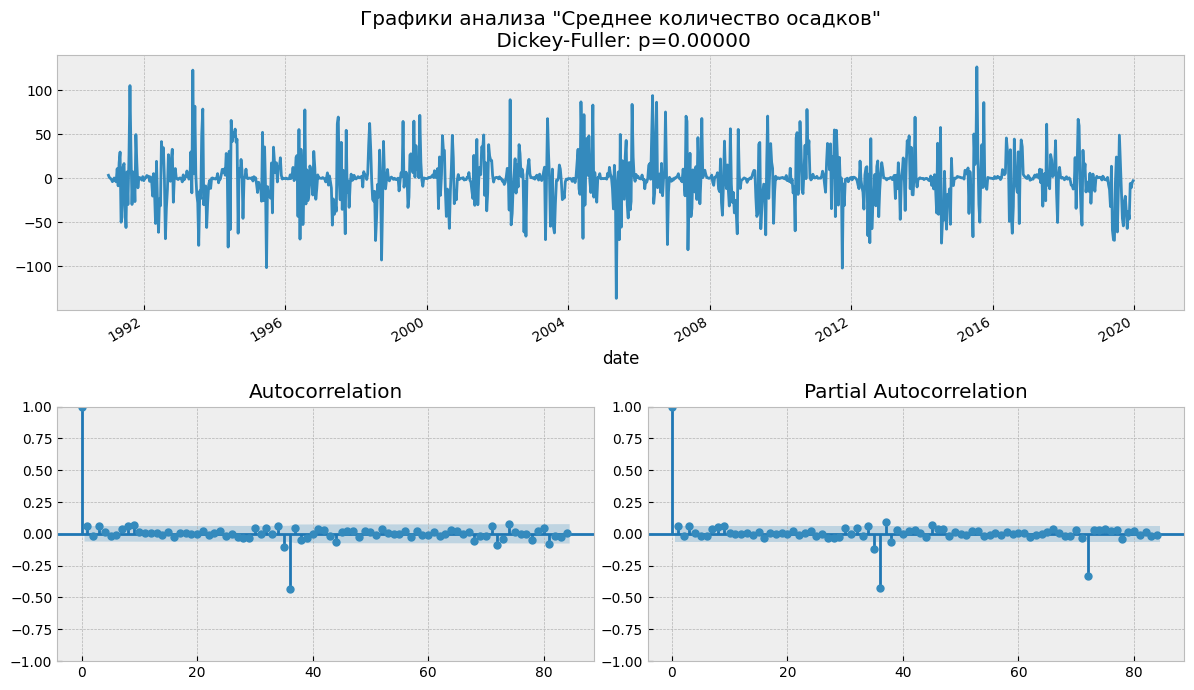

In [ ]:
#Есть сезонность, избавляемся
#Применяем сезонное дифференцирование
#В результате дифференцирования p-value стало еще меньше, а также оно и до этого было очень мало, так что ряд как был стационарным так и остался.
rainfall_diff = data['mean_rainfall'] - data['mean_rainfall'].shift(36)
tsplot(rainfall_diff[36:], lags=84)

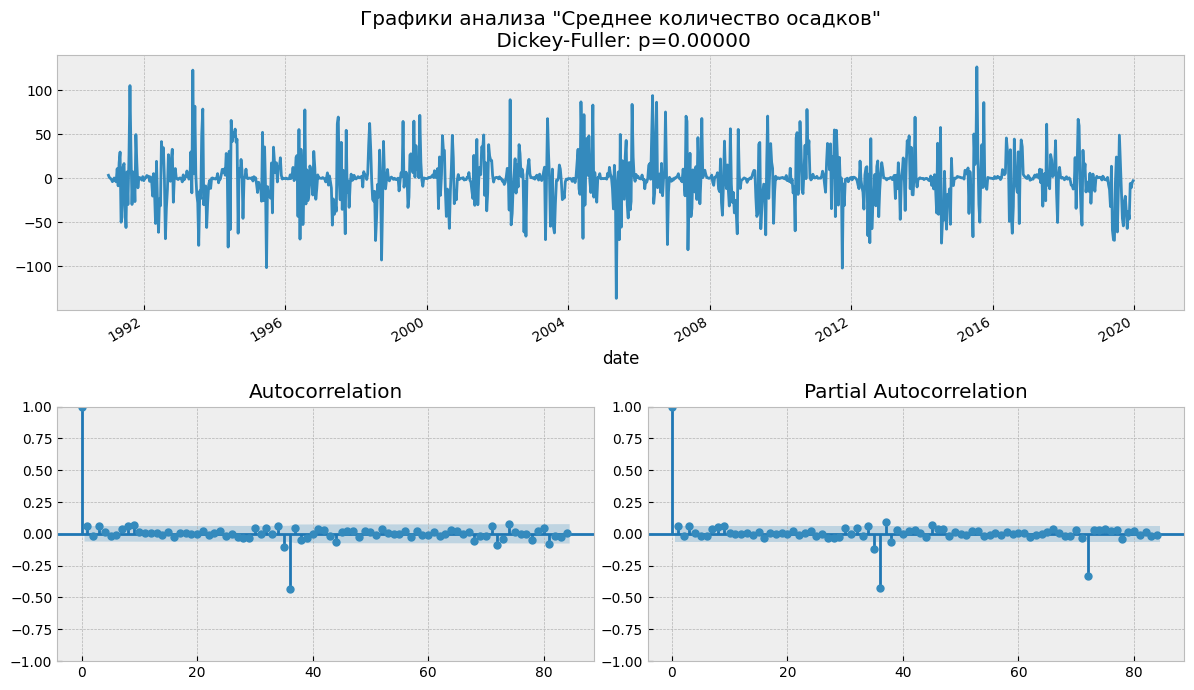

In [ ]:
tsplot(rainfall_diff[36:], lags=84)

In [ ]:
# Установка параметров модели, выбрали
order = (1, 0, 1)  # (p, d, q) p=1 последнее значение отставание PACF, d=0 не проводили дифференцирование, q=1 после 1 лага, остальные лаги становятся не значительными
seasonal_order = (0, 1, 0, 72)  # (P, D, Q, s) P,Q = 0, D=1 сезонное дифференцирование было 1 раз, s = 36 такой же как период

# Обучение модели SARIMA с указанными параметрами
sarima_model = sm.tsa.statespace.SARIMAX(data['mean_rainfall'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
# Вывод статистики модели
print(sarima_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                       mean_rainfall   No. Observations:                 1078
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 72)   Log Likelihood               -4796.410
Date:                             Sun, 03 Mar 2024   AIC                           9598.820
Time:                                     11:42:46   BIC                           9613.555
Sample:                                          0   HQIC                          9604.419
                                            - 1078                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4655      0.419     -1.110      0.267      -1.288       0.357
ma.L1          0.5059      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


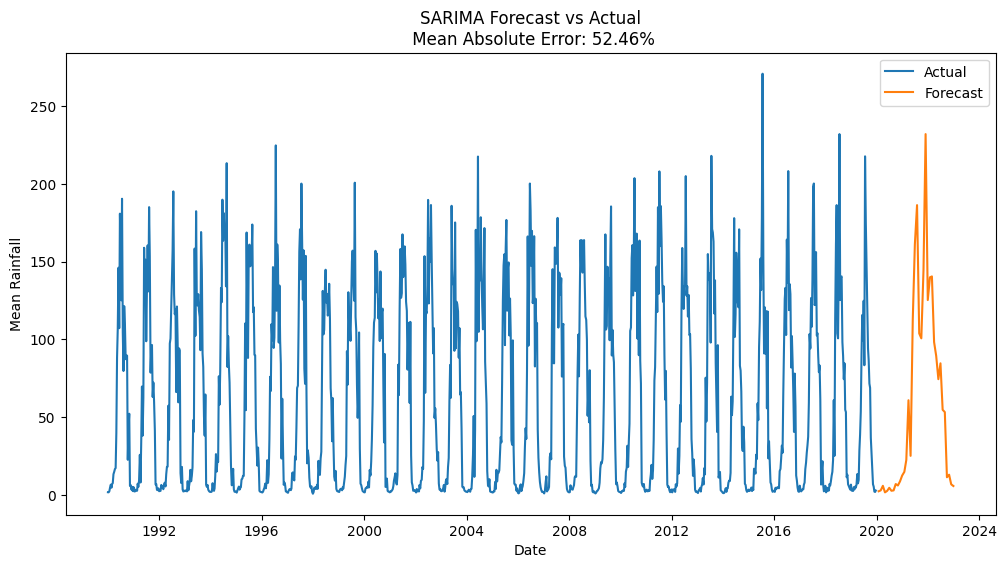

In [ ]:
# Определение последней доступной даты в наборе данных
last_date = data.index[-1]

# Определение количества шагов для прогнозирования (например, 36 месяцев вперед)
n_steps = 36

# Генерация прогноза на n_steps вперед с указанием начальной даты
forecast_dates = pd.date_range(start=last_date, periods=n_steps + 1, freq='M')[1:]
forecast = sarima_fit.forecast(steps=n_steps)

# Визуализация прогноза вместе с исходными данными
plt.figure(figsize=(12, 6))
plt.plot(data['mean_rainfall'], label='Actual')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.title('SARIMA Forecast vs Actual\n Mean Absolute Error: {:.2f}%'.format(mae_baseline))
plt.xlabel('Date')
plt.ylabel('Mean Rainfall')
plt.legend()
plt.show()
#SARIMA предсказывает прогноз с вероятностью 52%

**Классическая модель**

In [ ]:
#Создание копии датасета
data1 = pd.DataFrame(data['mean_rainfall'].copy())
data1.columns = ["y"]

In [ ]:
# Добавляем лаги
for i in range(6, 37):
    data1["lag_{}".format(i)] = data1.y.shift(i)

In [ ]:
#Добавляем столбцы year и month с количеством соотвественно.
data1.index = pd.to_datetime(data1.index)
data1["year"] = data1.index.year
data1["month"] = data1.index.month

In [ ]:
#Скользящее окно с размером окна 4
data1['rolling_mean'] = data1['y'].rolling(window=4).mean()

In [ ]:
# Просмотр последних 7 значений датасета
data1.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,year,month,rolling_mean
date,,,,,,,,,,,,,,,,,,,,,
2019-10-21,27.367,174.259,217.653,83.297,124.734,99.326,115.623,90.929,53.567,38.641,...,5.613,6.700,12.882,11.245,53.160,54.645,84.529,2019,10,51.06075
2019-11-01,16.856,94.172,174.259,217.653,83.297,124.734,99.326,115.623,90.929,53.567,...,4.382,5.613,6.700,12.882,11.245,53.160,54.645,2019,11,37.40925
2019-11-11,6.737,86.126,94.172,174.259,217.653,83.297,124.734,99.326,115.623,90.929,...,3.332,4.382,5.613,6.700,12.882,11.245,53.160,2019,11,21.90575
2019-11-21,5.216,71.462,86.126,94.172,174.259,217.653,83.297,124.734,99.326,115.623,...,6.501,3.332,4.382,5.613,6.700,12.882,11.245,2019,11,14.04400
2019-12-01,2.022,68.751,71.462,86.126,94.172,174.259,217.653,83.297,124.734,99.326,...,2.645,6.501,3.332,4.382,5.613,6.700,12.882,2019,12,7.70775
2019-12-11,1.780,36.663,68.751,71.462,86.126,94.172,174.259,217.653,83.297,124.734,...,3.084,2.645,6.501,3.332,4.382,5.613,6.700,2019,12,3.93875
2019-12-21,2.694,27.367,36.663,68.751,71.462,86.126,94.172,174.259,217.653,83.297,...,2.460,3.084,2.645,6.501,3.332,4.382,5.613,2019,12,2.92800


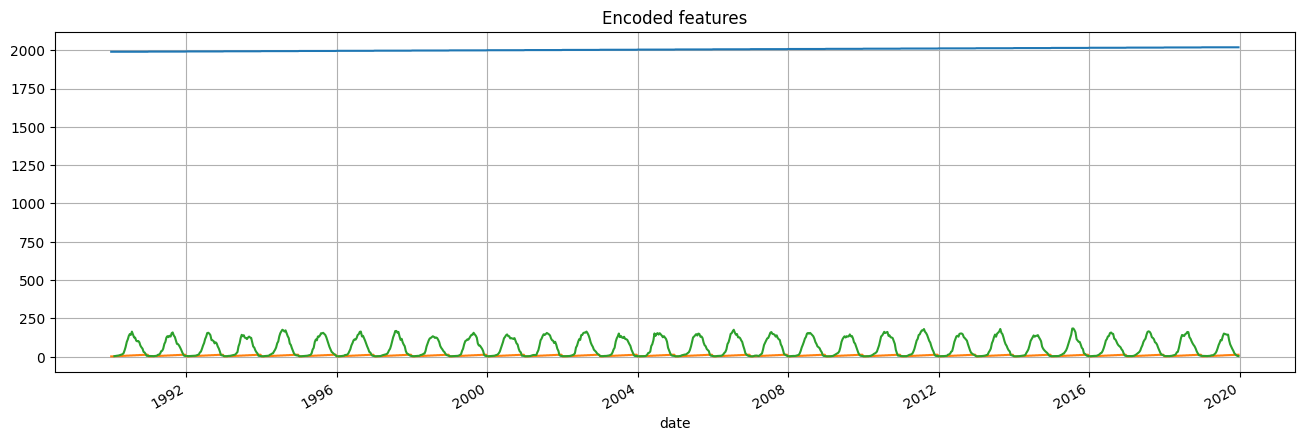

In [ ]:
#Визуализация
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data1.year.plot()
data1.month.plot()
data1.rolling_mean.plot()
plt.grid(True);

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [ ]:
y = data1.dropna().y
X = data1.dropna().drop(['y'], axis=1)

# Резерв 30% для теста
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_median_absolute_error")
        mse_met = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mse_met + scale * deviation)
        upper = prediction + (mse_met + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);


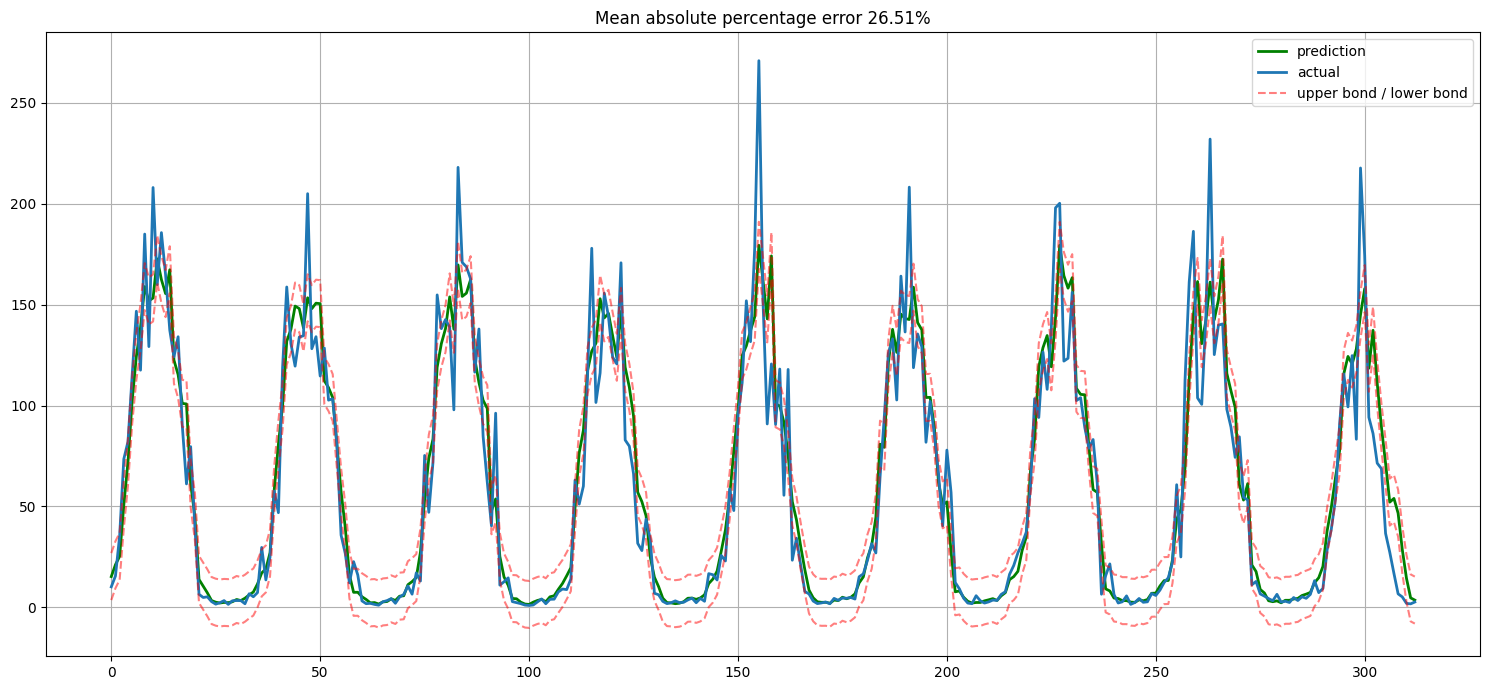

In [ ]:
plotModelResults(rf, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)

Сравним MAE с другими методами:
*   RandomForestRegressor - 26%
*   SARIMA - 52,46%
*   Наивный прогноз - 52.46%


**Интерпретация**

In [ ]:
#Permutation importances
X_train_scaled1 = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns
)
X_test_scaled1 = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns
)

In [ ]:
from sklearn.inspection import permutation_importance

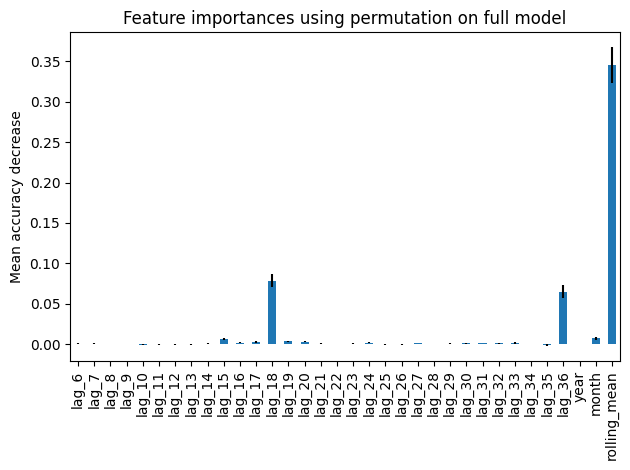

In [ ]:
importances = permutation_importance(rf, X_test_scaled1, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
#36 лаг выделяется больше всех, потому что это период, скользящего среднего (4).

In [ ]:
!pip install -U numpy==1.23.1 shap lime # need a restart after the run

import shap
from lime import lime_tabular

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled1.values,
    feature_names=X_train.columns,
    class_names=['y'],
    verbose=True,
    mode='regression',
)
i = 37
exp = explainer.explain_instance(X_test.iloc[i].values, rf.predict, num_features=5);

Intercept 50.95775206834617
Prediction_local [96.52959939]
Right: 119.43965000000001


In [ ]:
exp.show_in_notebook(show_table=True)
#На предсказанную переменную влияют rolling_mean и 36 лаг.

**SHAP**

In [ ]:
explainer = shap.TreeExplainer(rf)

In [ ]:
#Для одного объекта
choosen_instance = X_test_scaled1.loc[[100]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)
#Наиболее значимые признаки 18,36 лаги и rolling_mean

In [ ]:
choosen_instance = X_test_scaled1.loc[[4]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

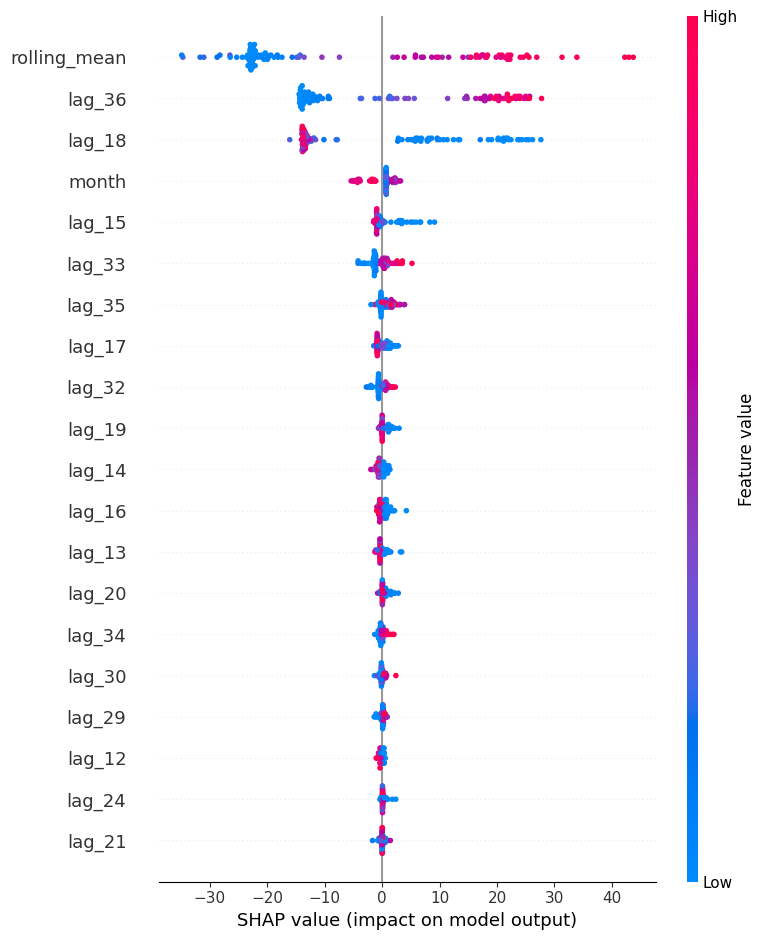

In [ ]:
#Для всей модели
shap_values = explainer.shap_values(X_train_scaled1.iloc[:100])
shap.summary_plot(shap_values, X_train_scaled1.iloc[:100])
#Зависимость от rolling_mean связано напрямую - > чем признак становится больше, тем СРД значение температуры выше.